DRKG

Adapted from: https://github.com/gnn4dr/DRKG/blob/master/drkg_with_dgl/loading_drkg_in_dgl.ipynb

In [1]:
import pandas as pd
import numpy as np
import os 
import torch_geometric.transforms as T
import torch
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric
from torch_geometric.nn import SAGEConv, to_hetero
from   torch.utils.data      import Dataset, DataLoader
from   torch_geometric.data  import Data
from   torch_geometric.utils import negative_sampling


from torch_geometric.nn           import SAGEConv, to_hetero
from SIMP_LLM.dataloader_mappings import load_graph,load_csv_as_list


from SIMP_LLM.models              import  GATStack,GNNStack,LinkPredictorMLP,CosineSimilarityModel,save_torch_model
from SIMP_LLM.train_utils         import  forward_pass, train,train_with_triplet,evaluate,   filter_edge_index_by_value,split_edge_index,get_negative_edges

import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

from sklearn         import metrics
from sklearn.metrics import ConfusionMatrixDisplay


import copy

/opt/conda/envs/simp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Graph

In [2]:
#triplets =[('Compound', 'Compound_treats_the_disease', 'Disease')] # Uncomment this line 
triplets     = load_csv_as_list('triplets.csv')                     # triplets of form (tail, relationship,head)
data         = load_graph(triplets,random_embeddings=False)                                # Load Graph based on triplets (You can selet the triplets 
dictionaries = torch.load("data2/mapping_dict")
#print(data)
#print(data["Compound", "Compound_treats_the_disease", "Disease"].edge_index)

data2


## GRAPH SAGE

#### 1 Masking Sanity Check

In [3]:
edge_index = torch.tensor([[0, 0, 0, 1, 1, 2, 2, 3,4,5,5,5,5,5], [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]])
print(f"Oringal Edge index:\n{edge_index }\n: {edge_index.shape}\n")
edge_index_1 , edge_index_2 = split_edge_index(edge_index ,percentage = 0.5,verbose=True)

Oringal Edge index:
tensor([[ 0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
: torch.Size([2, 14])

##############
Edge Index 1: torch.Size([2, 5])

Edge Index 2: torch.Size([2, 9])
##############


### 2 Mask Real Data 

In [4]:
## SPLIT TRAIN, TEST, VAL
edge_index_train , edge_index_validation_test          = split_edge_index(edge_index = data["Compound", "Compound_treats_the_disease", "Disease"].edge_index ,percentage = 0.9,verbose=True)
edge_index_validation ,edge_index_test                 = split_edge_index(edge_index = edge_index_validation_test  ,percentage = 0.5,verbose=True)


## Furthere split into EMBED and PREDICT for every split ###
edge_index_train_embed , edge_index_train_predict      = split_edge_index(edge_index = edge_index_train ,percentage = 0.8,verbose=True)
edge_index_val_embed   , edge_index_val_predict        = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)
edge_index_test_embed  , edge_index_test_predict       = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)





### Train ###
data_train_embed = copy.deepcopy(data)
data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_embed
print(data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_train_predict = copy.deepcopy(data)
data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_predict 
print(data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

### Val ###
data_val_embed = copy.deepcopy(data)
data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_embed 
print(data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_val_predict = copy.deepcopy(data)
data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_predict
print(data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)



### Test ###
data_test_embed = copy.deepcopy(data)
data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_embed 
print(data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_test_predict = copy.deepcopy(data)
data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_predict
print(data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)




##############
Edge Index 1: torch.Size([2, 40666])

Edge Index 2: torch.Size([2, 7888])
##############
##############
Edge Index 1: torch.Size([2, 1969])

Edge Index 2: torch.Size([2, 5919])
##############
##############
Edge Index 1: torch.Size([2, 30998])

Edge Index 2: torch.Size([2, 9668])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
torch.Size([2, 30998])
torch.Size([2, 9668])
torch.Size([2, 972])
torch.Size([2, 997])
torch.Size([2, 972])
torch.Size([2, 997])


###  3 Compile Model 

In [5]:
epochs        = 500
hidden_dim    = 524      
dropout       = 0.7
num_layers    = 3
learning_rate = 1e-4
node_emb_dim  = 768
device        = "cpu"
head          = "COSINE"    # one of   "MLP", "COSINE"
backbone      = "GraphSage" # one of  "GraphSage","GAT"
Triplet_loss  = True
Margin        = 2.0

#head          = "MLP_ONLY" 
#head          = "MLP"


#GATStack,GNNStack

if Triplet_loss == True:
    triplet_loss = nn.TripletMarginLoss(margin=Margin , p=2)

if backbone == "GraphSage":
    HomoGNN         = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
elif backbone == "GAT":
    HomoGNN         = GATStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) 
    
embed_model     = to_hetero(HomoGNN   , data.metadata(), aggr='sum')
if head == "MLP" or head == "MLP_ONLY":
    link_predictor  = LinkPredictorMLP(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
if head == "COSINE":
    link_predictor = CosineSimilarityModel(input_dim=524 ).to(device)

#optimizer      = torch.optim.AdamW(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate, weight_decay=1e-4)
elif head ==  "MLP_ONLY":
    optimizer       = torch.optim.Adam(list(link_predictor.parameters() ), lr=learning_rate)
if head ==  "MLP":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate)
elif head == "COSINE":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) , lr=learning_rate)
    

#print(embed_model)
print(link_predictor)
print(f"Models Loaded to {device}")
data.to(device)
embed_model.to(device)
print()

/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Side Effect' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Biological Process' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Cellular Component' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_

CosineSimilarityModel(
  (cos): CosineSimilarity()
)
Models Loaded to cpu



In [6]:
embed_model 

GraphModule(
  (convs): ModuleList(
    (0): ModuleDict(
      (Compound__activation__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__allosteric_modulation__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__antagonism__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__antibody__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__binding__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__blocking__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__inhibition__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__modulation__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__other__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__partial_agonism__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__positive_allosteric_modulation__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__carrier__Gene): SAGEConv(768, 524, aggr=mean)
      (Compound__drugdrug_interaction__Compound): SAGEConv(768, 524, aggr=mean)
      (Compound__enzyme__Gene): SAGEConv(768, 524,

# 4 Train

Epoch 1: loss: 28.10173
Epoch 2: loss: 7.93227
Epoch 3: loss: 4.35395
Epoch 4: loss: 3.56858
Epoch 5: loss: 3.10707
Epoch 6: loss: 3.01763
Epoch:  6
Youdens  index: 0.5008 Sensitivity: 0.656 Specificity: 0.4975 AUC: 0.5961445017097431


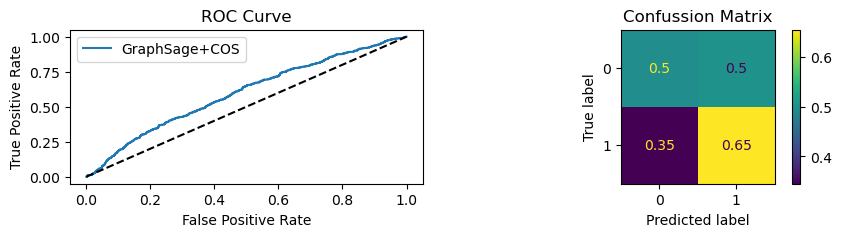

Accuracy:0.5672016048144434
Replacing models:   
with: Best models at GraphSage_epoch_6.pt  link_predictor_epoch_6.pt
Saving Model in Path GraphSage_epoch_6.pt
Saving Model in Path link_predictor_epoch_6.pt
Epoch 7: loss: 2.77251
Epoch 8: loss: 2.53248
Epoch 9: loss: 2.4173
Epoch 10: loss: 2.35382
Epoch 11: loss: 2.14939
Epoch 12: loss: 2.07102
Epoch:  12
Youdens  index: 0.5009 Sensitivity: 0.5476 Specificity: 0.7412 AUC: 0.6877508151334646


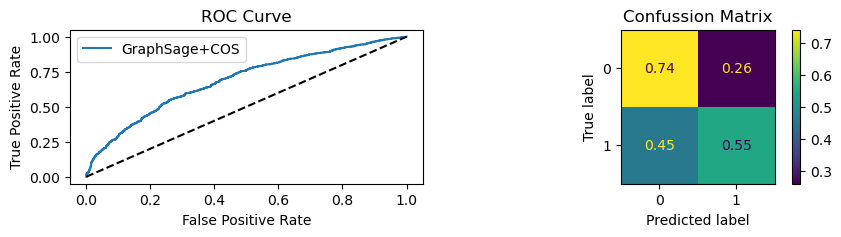

Accuracy:0.6409227683049148
Replacing models: GraphSage_epoch_6.pt  link_predictor_epoch_6.pt
with: Best models at GraphSage_epoch_12.pt  link_predictor_epoch_12.pt
Saving Model in Path GraphSage_epoch_12.pt
Saving Model in Path link_predictor_epoch_12.pt
Epoch 13: loss: 1.93698
Epoch 14: loss: 1.88605
Epoch 15: loss: 1.80241
Epoch 16: loss: 1.69714
Epoch 17: loss: 1.65174
Epoch 18: loss: 1.56837
Epoch:  18
Youdens  index: 0.4904 Sensitivity: 0.675 Specificity: 0.679 AUC: 0.718301846361552


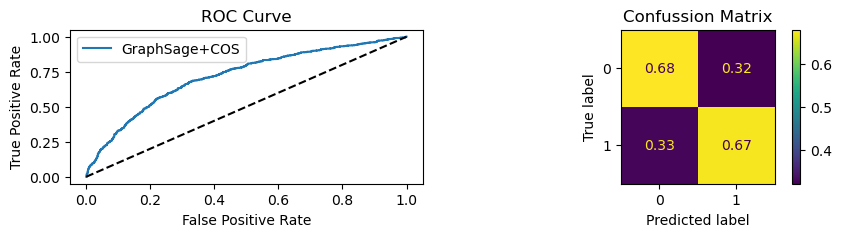

Accuracy:0.6394182547642929
Epoch 19: loss: 1.49445
Epoch 20: loss: 1.48637
Epoch 21: loss: 1.47195
Epoch 22: loss: 1.38421
Epoch 23: loss: 1.36923
Epoch 24: loss: 1.36658
Epoch:  24
Youdens  index: 0.4886 Sensitivity: 0.663 Specificity: 0.7121 AUC: 0.7291915867964978


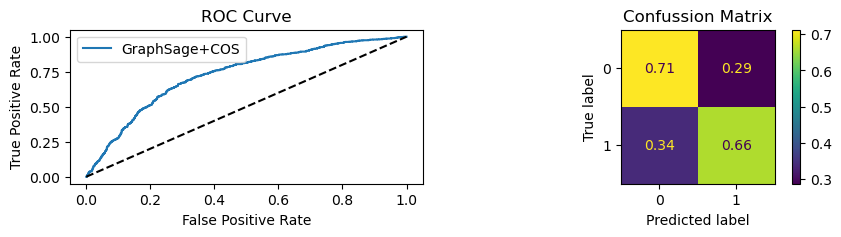

Accuracy:0.6258776328986961
Epoch 25: loss: 1.27371
Epoch 26: loss: 1.23493
Epoch 27: loss: 1.23149
Epoch 28: loss: 1.22068
Epoch 29: loss: 1.17429
Epoch 30: loss: 1.15391
Epoch:  30
Youdens  index: 0.4861 Sensitivity: 0.655 Specificity: 0.7252 AUC: 0.7438217360204988


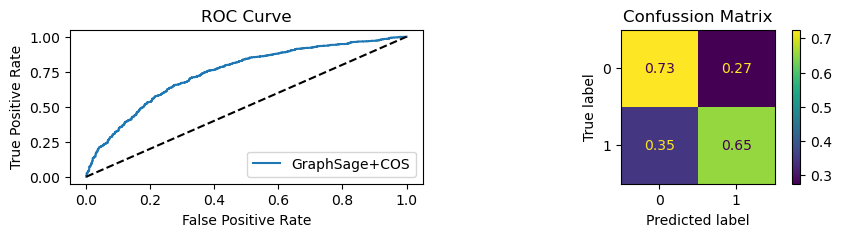

Accuracy:0.6143430290872618
Epoch 31: loss: 1.14552
Epoch 32: loss: 1.13115
Epoch 33: loss: 1.1368
Epoch 34: loss: 1.09952
Epoch 35: loss: 1.05776
Epoch 36: loss: 1.05328
Epoch:  36
Youdens  index: 0.4812 Sensitivity: 0.7141 Specificity: 0.7031 AUC: 0.7491224928546925


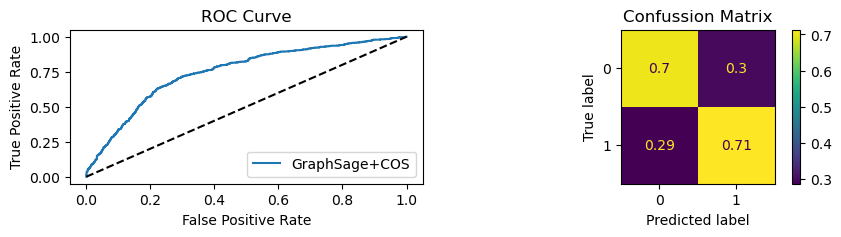

Accuracy:0.6068204613841525
Epoch 37: loss: 1.04492
Epoch 38: loss: 1.04618
Epoch 39: loss: 1.01853
Epoch 40: loss: 1.01392
Epoch 41: loss: 1.02345
Epoch 42: loss: 0.99653
Epoch:  42
Youdens  index: 0.4801 Sensitivity: 0.7131 Specificity: 0.7182 AUC: 0.7566028074192487


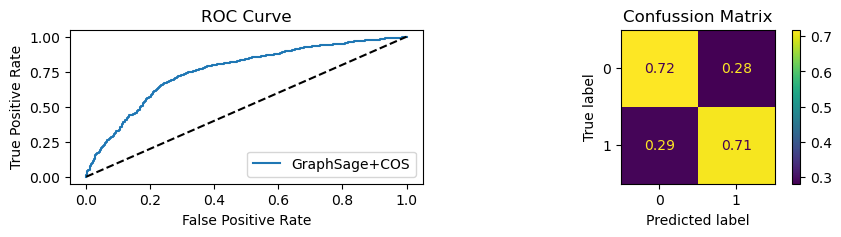

Accuracy:0.6013039117352056
Epoch 43: loss: 0.99267
Epoch 44: loss: 0.95171
Epoch 45: loss: 0.96583
Epoch 46: loss: 0.97214
Epoch 47: loss: 0.9611
Epoch 48: loss: 0.95888
Epoch:  48
Youdens  index: 0.4716 Sensitivity: 0.7733 Specificity: 0.5978 AUC: 0.726771085573672


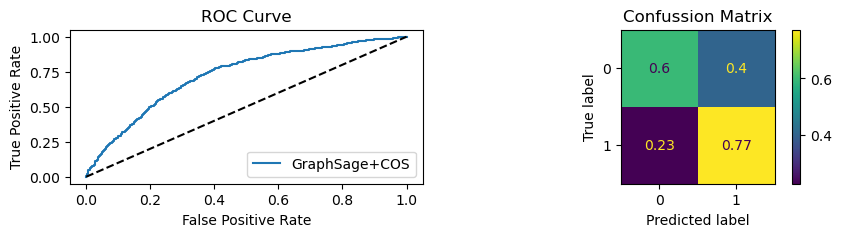

Accuracy:0.5787362086258776
Epoch 49: loss: 0.93934


In [ ]:
train_loss                      = []
train_accuracy                  = []
show_metrics_every              = 20
best_accuracy                   = 0 
best_graphsage_model_path       = ""
best_link_predictor_model_path  = ""
epochs                          = 200
print_every_epoch               = 6
threshold                       = 0.5
best_accuracy                   = 0 
best_graphsage_model_path       = ""
best_link_predictor_model_path  = ""
val_accuracy                    = []




for epoch in range(1,epochs):
    ### TRAIN ####
    if Triplet_loss:
        loss = train_with_triplet(model =  embed_model , link_predictor = link_predictor, data_embed = data_train_embed,data_predict = data_train_predict,data_sample =data, optimizer =  optimizer,triplet_loss= triplet_loss ,device=device)
        
    else:
        loss = train(model =  embed_model , link_predictor = link_predictor, data_embed = data_train_embed,data_predict = data_train_predict,data_sample =data, optimizer =  optimizer,device=device,head=head)
    train_loss.append(loss)
    print(f"Epoch {epoch}: loss: {round(loss, 5)}")
    
    if epoch % print_every_epoch   == 0:
        print("Epoch: ", epoch)
        accuracy = evaluate(embed_model ,link_predictor,data_val_embed,data_val_predict,data_sample=data,threshold=threshold,show_extra_metrics=True)
        print(f"Accuracy:{accuracy}")
        val_accuracy.append(accuracy)
        ### SAVE ###
        if accuracy > best_accuracy :
            if os.path.exists(best_graphsage_model_path):
                os.remove(best_graphsage_model_path)

            if os.path.exists(best_link_predictor_model_path):
                os.remove(best_link_predictor_model_path)
            print(f"Replacing models: {best_graphsage_model_path }  {best_link_predictor_model_path}")

            best_accuracy  = accuracy
            best_graphsage_model_path      = f"{backbone}_epoch_{epoch}.pt"
            best_link_predictor_model_path =  f"link_predictor_epoch_{epoch}.pt"
            print(f"with: Best models at {best_graphsage_model_path }  {best_link_predictor_model_path}")
            save_torch_model(embed_model ,         epoch=epoch,PATH=best_graphsage_model_path ,     optimizer=optimizer)
            save_torch_model(link_predictor,epoch=epoch,PATH=best_link_predictor_model_path, optimizer=optimizer)


#### Load Best Models ####

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
checkpoint = torch.load(best_graphsage_model_path)
embed_model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint
torch.save(train_loss, 'train_loss.pt')

       


    




In [ ]:
test_accuracy = evaluate(embed_model ,link_predictor,data_test_embed,data_test_predict,data_sample=data,threshold=0.5,show_extra_metrics=True)
torch.save(test_accuracy, 'test_accuracy.pt')

In [ ]:
torch.save(train_loss, 'train_loss.pt')

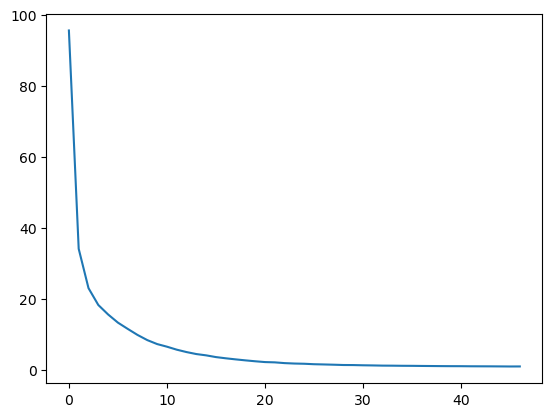

In [9]:
plt.plot(train_loss)



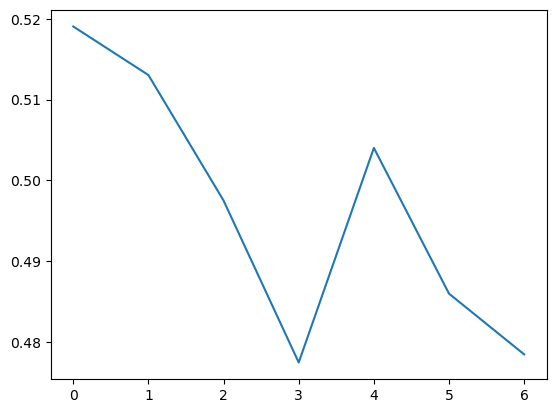

In [10]:
plt.plot(val_accuracy)

In [25]:
#### Load Best Models ####
best_graphsage_model_path      = os.path.join("Saved_models","GraphSageCosine","GraphSage_epoch_58.pt")
best_link_predictor_model_path = os.path.join("Saved_models","GraphSageCosine","link_predictor_epoch_58.pt")
print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
                                              
                                              
checkpoint = torch.load(best_graphsage_model_path  )
embed_model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint
torch.save(train_loss, 'train_loss.pt')

Loading best models:  Saved_models/GraphSageCosine/GraphSage_epoch_58.pt  Saved_models/GraphSageCosine/link_predictor_epoch_58.pt


Youdens  index: 0.5726 Sensitivity: 0.9338 Specificity: 0.8445


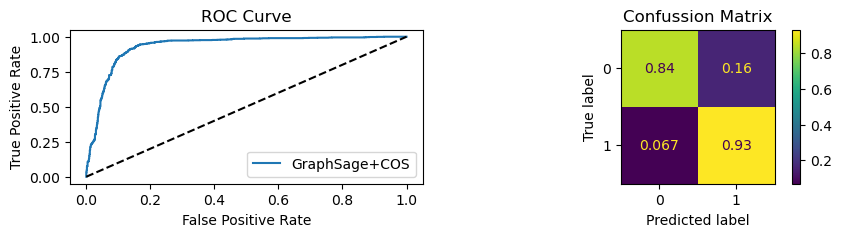

In [26]:
test_accuracy = evaluate(embed_model ,link_predictor,data_test_embed,data_test_predict,data_sample=data,threshold=0.5,show_extra_metrics=True)
